## Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import sys
import lz4.frame
import random as rn
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from pathlib import Path
from settings import (SPEED_DATA_PATH, 
                      WIND_DATA_PATH, GEO_PATH)
from compress.sprintz_encode import compress_sprintz, get_sprintz_memory, decompress_sprintz
from compress.bypass import spatial_clustering, geo_sort, get_corr_lists
from compress.general_functions import get_memory_init, get_float_bytes
from compress.xor_encode import xor_compress_df, get_xor_memory_df, decompress_xor, decompress_xor_df
#from compress.xor_decode import decompress_xor, decompress_xor_df
from compress.lz4_encode import LZ4_compress_df, get_lz4_memory, LZ4_decompress_df
from compress.spatial_lz4 import spatial_clustering_PCA_LZ4, spatial_lz4_decompress
from compress.spatial_xor import spatial_clustering_xor, spatial_XOR_decompress
from compress.spatial_sprintz import spatial_clustering_sprintz, spatial_sprintz_decompress
import seaborn as sns
warnings.filterwarnings("ignore")

## Params

In [2]:
table_params = [{
                'selector': 'caption',
                'props': [
                    ('color', 'Blue'),
                    ('font-size', '16pt'),
                    ('font-weight', 'bold'),
                    ('text-align', 'center'),
                    ('caption-side', 'top'),
                    ('padding', '10px')
                ]
            },
            {
                'selector': 'th',
                'props': [('font-size', '14pt')]
            }]

## Data

In [3]:
# int time series
speed_init = pd.read_csv(SPEED_DATA_PATH, parse_dates=[0], index_col=[0])# данные заполненности дорог
speed_init.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2015-08-31 18:22:00 to 2015-09-17 16:24:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   2500 non-null   int64
dtypes: int64(1)
memory usage: 39.1 KB


In [4]:
speed_init['index'] = np.arange(speed_init.shape[0])
sensor_data = {}

for i in range(5):
    sensor_data[f'sensor_{i+1}'] = speed_init.loc[speed_init['index'] % 5 == i,
                                             ['value']]['value'].to_list()

df_speed = pd.DataFrame(sensor_data)
print('DataFrame shape:', df_speed.shape)
df_speed.head()

DataFrame shape: (500, 5)


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,90,80,84,94,90
1,91,62,96,75,84
2,86,93,69,88,71
3,74,68,88,71,87
4,82,68,73,69,57


In [5]:
df_speed.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,82.126000,81.538000,81.862000,81.786000,82.222000
std,8.404963,9.247897,8.155488,8.913085,8.983659
min,43.000000,28.000000,53.000000,29.000000,20.000000
25%,77.000000,76.000000,77.000000,76.000000,77.000000
50%,83.000000,82.000000,82.000000,82.000000,83.000000
75%,87.000000,88.000000,87.000000,88.000000,88.000000
max,109.000000,103.000000,106.000000,106.000000,105.000000


In [6]:
corr_speed = df_speed.corr()
styled_corr_speed = corr_speed.style.set_caption("Correlation matrix of Emhires Dataset") \
                                  .background_gradient(cmap='coolwarm') \
                                  .set_properties(**{'font-size': '14pt'}) \
                                  .set_table_styles(table_params)

# Отображение матрицы корреляции
display(styled_corr_speed)

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
sensor_1,1.000000,0.216599,0.170231,0.160731,0.129970
sensor_2,0.216599,1.000000,0.238876,0.241704,0.254247
sensor_3,0.170231,0.238876,1.000000,0.342827,0.135786
sensor_4,0.160731,0.241704,0.342827,1.000000,0.326703
sensor_5,0.129970,0.254247,0.135786,0.326703,1.000000


In [7]:
df_wind_init = pd.read_csv(WIND_DATA_PATH)
df_wind_init.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262968 entries, 0 to 262967
Data columns (total 29 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AT      262968 non-null  float64
 1   BE      262968 non-null  float64
 2   BG      262968 non-null  float64
 3   CH      262968 non-null  float64
 4   CY      262968 non-null  int64  
 5   CZ      262968 non-null  float64
 6   DE      262968 non-null  float64
 7   DK      262968 non-null  float64
 8   EE      262968 non-null  float64
 9   ES      262968 non-null  float64
 10  FI      262968 non-null  float64
 11  FR      262968 non-null  float64
 12  EL      262968 non-null  float64
 13  HR      262968 non-null  float64
 14  HU      262968 non-null  float64
 15  IE      262968 non-null  float64
 16  IT      262968 non-null  float64
 17  LT      262968 non-null  float64
 18  LU      262968 non-null  float64
 19  LV      262968 non-null  float64
 20  NL      262968 non-null  float64
 21  NO      26

Возьмем данные о первых шести ветренных вышек.

In [8]:
df_wind = df_wind_init[['AT', 'BE', 'BG', 'CH', 'CZ', 'DE']]
df_wind = df_wind.head(10000)

Видим, что данные ненулевые через определенные промежутки времени. Это связано с тем, что отсутствует непрерывность замеров данных. Оставим только те строки, где есть хотя бы одно ненулевое значение.

In [9]:
# Ensure the correct columns are used
df_wind = df_wind.loc[(
    df_wind[['AT', 'BE', 'BG', 'CH', 'CZ', 'DE']] != 0).any(axis=1)].reset_index(drop=True)
df_wind.columns = [f'sensor_{i}' for i in range(df_wind.shape[1])]
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_0  5371 non-null   float64
 1   sensor_1  5371 non-null   float64
 2   sensor_2  5371 non-null   float64
 3   sensor_3  5371 non-null   float64
 4   sensor_4  5371 non-null   float64
 5   sensor_5  5371 non-null   float64
dtypes: float64(6)
memory usage: 251.9 KB


## Data analisys

In [10]:
corr_wind = df_wind.corr()
styled_corr_wind = corr_wind.style.set_caption("Correlation matrix of Emhires Dataset") \
                                  .background_gradient(cmap='coolwarm') \
                                  .set_properties(**{'font-size': '14pt'}) \
                                  .set_table_styles(table_params)

# Отображение матрицы корреляции
display(styled_corr_wind)

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
sensor_0,1.000000,0.692844,0.718031,0.858738,0.901123,0.844601
sensor_1,0.692844,1.000000,0.533855,0.723919,0.705373,0.862921
sensor_2,0.718031,0.533855,1.000000,0.637662,0.685302,0.661292
sensor_3,0.858738,0.723919,0.637662,1.000000,0.772007,0.839008
sensor_4,0.901123,0.705373,0.685302,0.772007,1.000000,0.884198
sensor_5,0.844601,0.862921,0.661292,0.839008,0.884198,1.000000


### Распределение

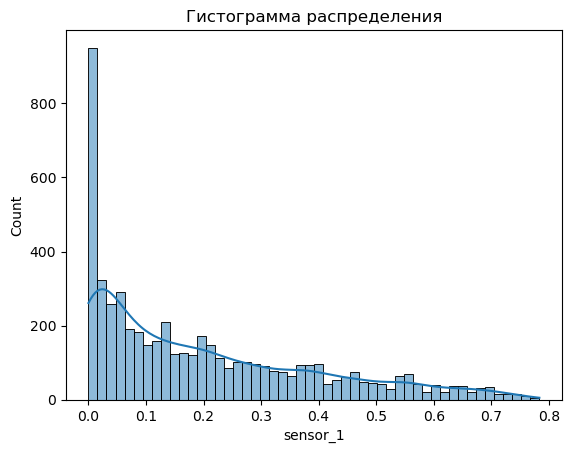

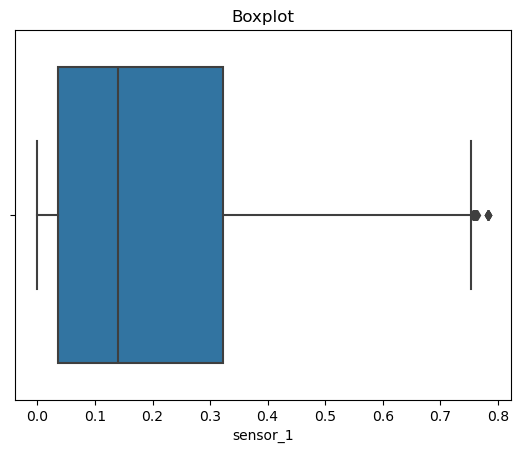

In [11]:
# Гистограмма + KDE
data = df_wind['sensor_1']
sns.histplot(data, kde=True, bins=50)
plt.title("Гистограмма распределения")
plt.show()

# Boxplot
sns.boxplot(x=data)
plt.title("Boxplot")
plt.show()

In [12]:
from scipy.stats import skew, kurtosis

skewness = skew(data)
kurt = kurtosis(data)

print(f"Асимметрия: {skewness:.2f}")
print(f"Эксцесс: {kurt:.2f}")

Асимметрия: 0.95
Эксцесс: -0.05


In [13]:
from scipy.stats import shapiro, normaltest

# Шапиро-Уилк (работает для небольших выборок < 5000)
stat, p = shapiro(data)
print(f"Шапиро-Уилк p-value: {p:.5f}")

# D’Agostino’s K-squared (для больших выборок)
stat, p = normaltest(data)
print(f"D’Agostino p-value: {p:.5f}")

Шапиро-Уилк p-value: 0.00000
D’Agostino p-value: 0.00000


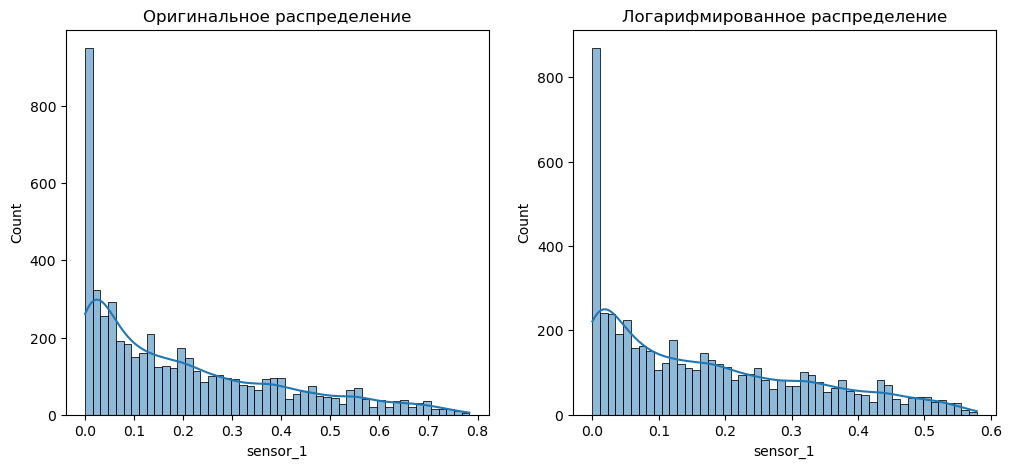

In [14]:
data_log = np.log1p(data)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data, kde=True, bins=50, ax=axes[0])
axes[0].set_title("Оригинальное распределение")

sns.histplot(data_log, kde=True, bins=50, ax=axes[1])
axes[1].set_title("Логарифмированное распределение")

plt.show()

### Шум

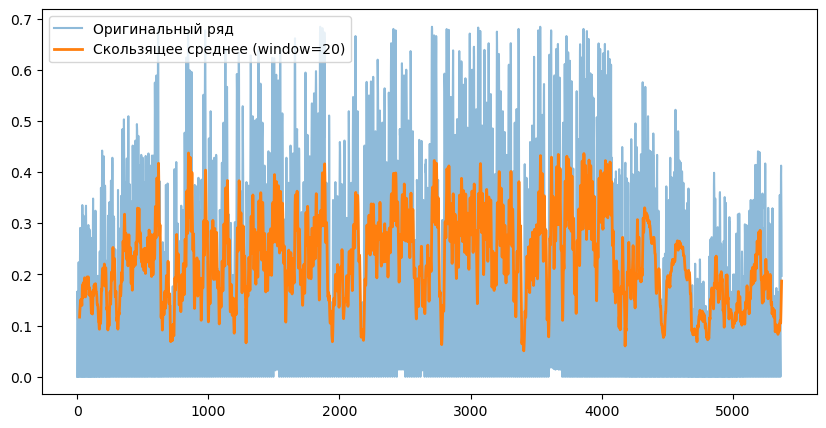

In [15]:
rolling_mean = df_wind.sensor_0.rolling(window=20).mean()

plt.figure(figsize=(10,5))
plt.plot(df_wind.sensor_0.values, label="Оригинальный ряд", alpha=0.5)
plt.plot(rolling_mean, label="Скользящее среднее (window=20)", linewidth=2)
plt.legend()
plt.show()

In [16]:
X = df_wind.sensor_0.values

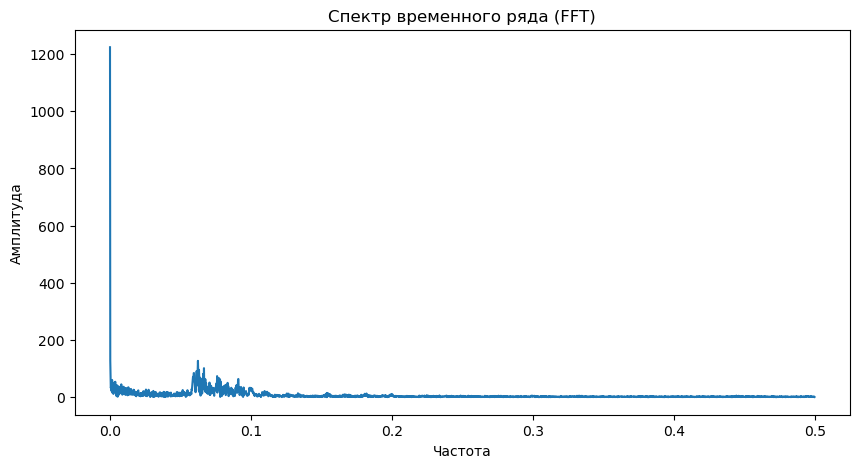

In [17]:
from scipy.fftpack import fft

X_fft = np.abs(fft(X))
freqs = np.fft.fftfreq(len(X))

plt.figure(figsize=(10,5))
plt.plot(freqs[:len(freqs)//2], X_fft[:len(X_fft)//2])
plt.title("Спектр временного ряда (FFT)")
plt.xlabel("Частота")
plt.ylabel("Амплитуда")
plt.show()

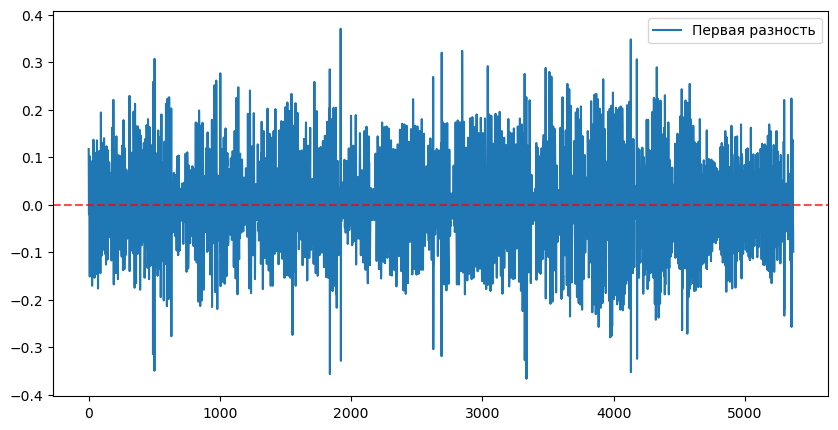

In [18]:
X_diff = np.diff(X)

plt.figure(figsize=(10,5))
plt.plot(X_diff, label="Первая разность")
plt.axhline(0, color='r', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [19]:
from scipy.stats import entropy

hist, _ = np.histogram(X, bins=50)
ent = entropy(hist)

print(f"Энтропия ряда: {ent:.3f}")

Энтропия ряда: 3.685


In [20]:
import pywt

wavelet = 'haar'
coeffs = pywt.wavedec(X, wavelet, level=3)

# Оценим долю энергии в каждом уровне разложения
energy_levels = [np.sum(np.abs(c)**2) for c in coeffs]

print("Энергия коэффициентов на каждом уровне разложения:", energy_levels)

Энергия коэффициентов на каждом уровне разложения: [356.04758554508646, 65.73701276035354, 27.73028362734523, 9.927217631002883]


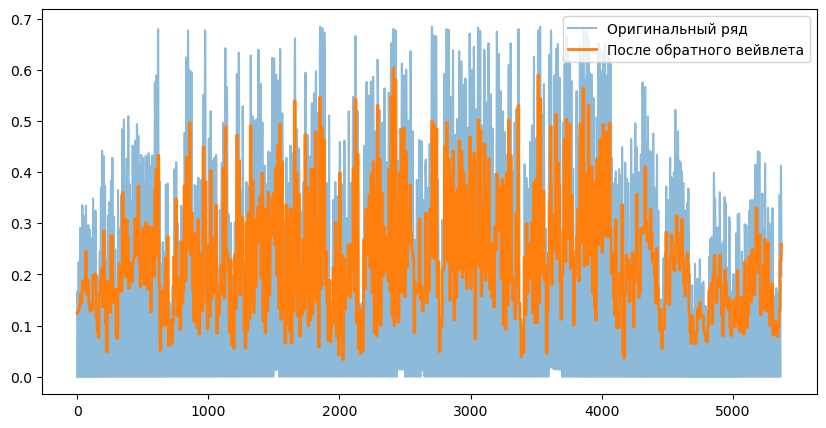

In [21]:
coeffs_filtered = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
X_restored = pywt.waverec(coeffs_filtered, wavelet)

plt.figure(figsize=(10,5))
plt.plot(X, label="Оригинальный ряд", alpha=0.5)
plt.plot(X_restored, label="После обратного вейвлета", linewidth=2)
plt.legend()
plt.show()

## Create or download geo_dict

In [22]:
def get_geo_dict(df):
    # make geo data
    sen_num = df.shape[1]
    x_y = []
    for i in range(sen_num):
        x_y.append([rn.uniform(.0, 6.0), rn.uniform(.0, 6.0)])
        print(f'sensor_{i}:', x_y[i])
    plt.grid(True)
    for i in range(len(x_y)):
        plt.plot(x_y[i][0], x_y[i][1], 'o', label = i)
        plt.legend(loc = 'best', fancybox = True, shadow = True)
    plt.plot(3*np.ones(300), np.arange(0, 6, 0.02))
    plt.plot(np.arange(0, 6, 0.02), 3*np.ones(300))
    geo_dict = dict(zip(df.columns, x_y))
    print(geo_dict)
    return dict(zip(df.columns, x_y))

sensor_0: [4.370713941141831, 5.747507989217377]
sensor_1: [5.397857667157046, 1.9355365729338554]
sensor_2: [1.3877396669245108, 5.1911122576427156]
sensor_3: [1.9153384919907617, 0.7532327298631094]
sensor_4: [1.26904829636013, 2.4366316299450053]
{'sensor_1': [4.370713941141831, 5.747507989217377], 'sensor_2': [5.397857667157046, 1.9355365729338554], 'sensor_3': [1.3877396669245108, 5.1911122576427156], 'sensor_4': [1.9153384919907617, 0.7532327298631094], 'sensor_5': [1.26904829636013, 2.4366316299450053]}


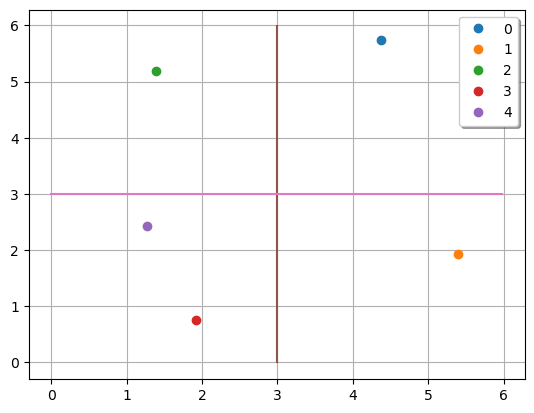

In [23]:
speed_geo_dict = get_geo_dict(df_speed)

In [24]:
display(styled_corr_wind)

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
sensor_0,1.000000,0.692844,0.718031,0.858738,0.901123,0.844601
sensor_1,0.692844,1.000000,0.533855,0.723919,0.705373,0.862921
sensor_2,0.718031,0.533855,1.000000,0.637662,0.685302,0.661292
sensor_3,0.858738,0.723919,0.637662,1.000000,0.772007,0.839008
sensor_4,0.901123,0.705373,0.685302,0.772007,1.000000,0.884198
sensor_5,0.844601,0.862921,0.661292,0.839008,0.884198,1.000000


In [25]:
#for best clustering
d = {'sensor_0': [1.1, 4.2],
     'sensor_1': [3.2, 1.9],
     'sensor_2': [3.8, 2.6],
     'sensor_3': [0.51, 4.9],
     'sensor_4': [1.2, 3.1],
     'sensor_5': [2.12, 3.9],
     'sensor_6': [0.8, 1.2],
     'sensor_7': [1.3, 0.9],}

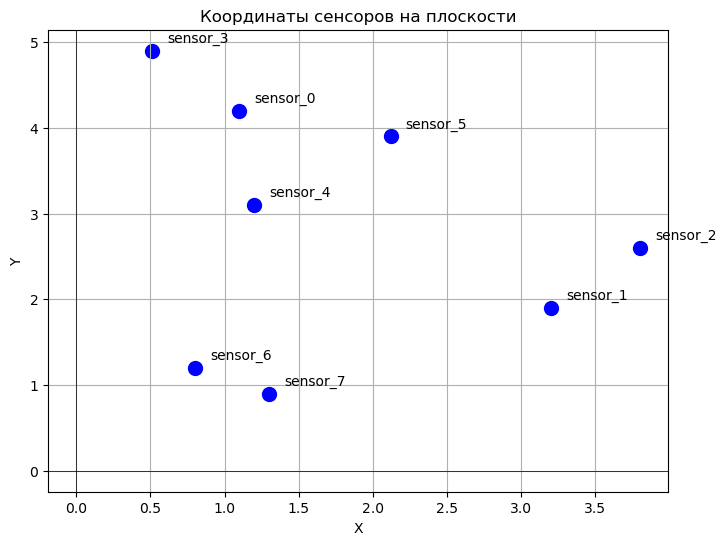

In [26]:
# Разделяем координаты
x_coords = [coord[0] for coord in d.values()]  # Координаты X
y_coords = [coord[1] for coord in d.values()]  # Координаты Y
labels = list(d.keys())  # Метки (названия сенсоров)

# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, color='blue', s=100)  # Точки на плоскости

# Добавляем подписи к точкам
for i, label in enumerate(labels):
    plt.text(x_coords[i] + 0.1, y_coords[i] + 0.1, label, fontsize=10)

# Настройка графика
plt.title('Координаты сенсоров на плоскости')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)  # Линия X=0
plt.axvline(0, color='black', linewidth=0.5)  # Линия Y=0
plt.show()

In [27]:
spatial_clustering(df_wind, d)

{'sensor_0': ['sensor_0', 'sensor_3', 'sensor_5', 'sensor_4'],
 'sensor_1': ['sensor_1'],
 'sensor_2': ['sensor_2']}

sensor_0: [5.137324238092544, 2.6968292858320764]
sensor_1: [4.723149861120651, 1.5483101909593797]
sensor_2: [1.2120359191944805, 4.261181396688549]
sensor_3: [0.7575196403611213, 3.7058128876549405]
sensor_4: [1.94794872595094, 5.082292319736975]
sensor_5: [4.031323681949626, 2.67995090996953]
{'sensor_0': [5.137324238092544, 2.6968292858320764], 'sensor_1': [4.723149861120651, 1.5483101909593797], 'sensor_2': [1.2120359191944805, 4.261181396688549], 'sensor_3': [0.7575196403611213, 3.7058128876549405], 'sensor_4': [1.94794872595094, 5.082292319736975], 'sensor_5': [4.031323681949626, 2.67995090996953]}


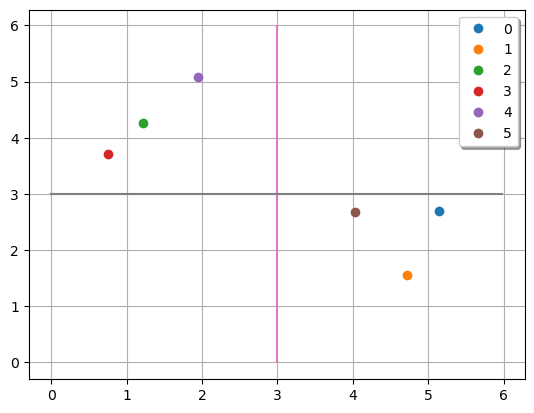

In [28]:
wind_geo_dict = get_geo_dict(df_wind)

In [29]:
print('Clusters for Emhires dataset:')
spatial_clustering(df_wind, wind_geo_dict)

Clusters for Emhires dataset:


{'sensor_0': ['sensor_0', 'sensor_5'],
 'sensor_1': ['sensor_1'],
 'sensor_2': ['sensor_2'],
 'sensor_3': ['sensor_3'],
 'sensor_4': ['sensor_4']}

In [30]:
import yaml

# Save wind_geo_dict to a YAML file
with open("wind_geo_dict_1.yaml", "w") as file:
    yaml.dump(wind_geo_dict, file)

print("wind_geo_dict has been saved as wind_geo_dict.yaml")

wind_geo_dict has been saved as wind_geo_dict.yaml


## Sprintz

In [31]:
speed_sprintz_res = compress_sprintz(df=df_speed, chunk_size=8)
speed_sprintz_res

[[['10110100', '10100000', '10101000', '10111100', '10110100'],
  '11111011011011000000010000100100101110010000100110110110000010001100011111110110001000000101001111100010101011000110101100110011101000000001110001111100101011010100001000011010010010001011101001011011001100000111011110100100111010100'],
 [['10100100', '10110100', '10111000', '1111110', '10001010'],
  '1101101101101100011110100101010001100100001011010100011101001001000110000111100001100010000011001000001011001011000111011011101110010010001101101010010001010010000000001010000111000011100110000000000001000100001111101010010001'],
 [['10101110', '10100000', '10101110', '10010110', '10010110'],
  '1101101101101100100101010100000110001000100101101010000001011100010011010010010001000100011001100010010011001010010010100101000100000100001110001110100100101011100111111000100111010010100110110011010010000110010001000101100000'],
 [['10110000', '10101010', '10111000', '10111100', '10111000'],
  '101110101110101010101000011111000100

In [32]:
df_speed

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,90,80,84,94,90
1,91,62,96,75,84
2,86,93,69,88,71
3,74,68,88,71,87
4,82,68,73,69,57
...,...,...,...,...,...
495,83,88,78,97,81
496,93,77,81,74,90
497,77,80,88,84,78
498,91,83,80,77,82


In [33]:
# Check for equals decodind and original data
decode_res = decompress_sprintz(speed_sprintz_res, chunk_size=7)
print('Check for decode:', df_speed.equals(decode_res))

Check for decode: True


In [34]:
get_memory_init(df_speed)
get_sprintz_memory(speed_sprintz_res)

Размер исходных данных: 17433 бит
Размер исходных данных: 2179 байт 

Память сжатых Sprintz данных: 15788 бит
Память сжатых Sprintz данных: 1973 байт 



## XOR

In [35]:
compressed_df = xor_compress_df(df_wind)
compressed_df

[['0',
  '110001011110111111110111110000100110101010110010010011100000110110010110101',
  '1000000001111011010111101110010001100000000101001001101100000001',
  '1000000000000111101101000101100000111111010011001000001011010011',
  '1000000000000111111001100011010001101101111010101011001100111101',
  '1000000000000110101011101110011010110011011100111111110101000011',
  '1000000000000010101100001111000101011000100000010110111011101010',
  '1000000001111101101001010111100101001110011011101011010001101010',
  '1000000001111111111100010010000101110101001100100011100111011001',
  '1011111111000011010101011001001001110000011011001101100001000000',
  '1011111110111010001000110001011010001110100000000010110111001101',
  '1000000001111100100111110100001011110001111101101010111011010100',
  '1000000000001010000110001110011101111010001010000110001010000000',
  '1000000000001100000000101001001010100010101101010001001010000011',
  '1000000000000001101001111110101111101100110110111010011011101001',
  

In [36]:
decompressed_df = decompress_xor_df(compressed_df)
print('Check for decode:', decompressed_df.equals(df_wind))

Check for decode: True


In [37]:
get_float_bytes(df_wind)
get_xor_memory_df(compressed_df)

Размер исходных данных: 2062464 бит
Размер исходных данных: 257808 байт 

Память сжатых XOR данных: 1995690 бит
Память сжатых XOR данных: 249461.25 байт


## LZ4

In [38]:
compressed_df = LZ4_compress_df(df_wind)
compressed_df

{'sensor_0': b'\x04"M\x18h@\xd8\xa7\x00\x00\x00\x00\x00\x00\x10\xf4N\x00\x00\x13\x00\x01\x00\xf0+\xb5lp\x92U\x13\xbe?\xb4\xf7d\xf2\xb1M\xc5?gu(\xcd\xe9\xf9\xc2?Z\xc6\xc2\xa0\xdd\x1f\xc5?\x19;\xb1\x13;\xb1\xc3?\xf3U0K\xca\x01\xc1?\x99\xe1^\x05\xb3\xa4\xbc?@\xd89\x00#\xc3?G\x00\xf3\x01\x00\xcd-\x80\x8e\x16#\xba?\x19\x83v\x7fT\xbc\xc6(\x00\x95\xcc?\x1a\xf3\xeb\xa7!\xa6\xc0@\x00\x84ND\xa3\xa8[\x00\xbd?0\x00uh2\xf9\xd8\xa6\xca\xbeH\x00u,)\x07D\x86{\xb5`\x00\xf5 \xb4?*^\xcbX\xc8?\xc0~\x1ab\nI\xcc?\x1a\xf8\x81\x1f\xf8\x81\xcf?\xa0\x12\xe4)A\x9e\xd2?\xd9\x0b\xbd\xd0\x0b\xbd\xd0?\x0c\x8cK\xe7.\xd7\xc5H\x00\xf5\x08\x17z\xa1\x17z\xa1\xb7?(\x03\x8c\x8dw]\xc3?&2\xdc\xab`\x96\xc4(\x00\x04\xc0\x00uA\x90\xa7\x04yJ\xc0\x90\x00u\x8d\xa2n\x01t\xb4\xb8H\x00\x90\'\xea\x16@G\x8b\xc1?\xe6\xf7\x00#\x1c\xd0 \x01\xf5\n\xd2?\xe5~<\xf5\xf8x\xd5?\xed\x94 O\t\xf2\xd4?\xb3\xcf\xb45\xfen\xce\x08\x00\x048\x01\x04 \x01\xf1\x12\xca\xaf\x9f\x86\x98B\xb2?\x81\x1b\xb9\x91\x1b\xb9\xc1?\'\xa7\xe7K\x04\\\xcd?\xa0\xb6\xc6\xdf\

In [39]:
decompressed_df = LZ4_decompress_df(compressed_df)
print('Check for decode:', decompressed_df.equals(df_wind))

Check for decode: True


In [40]:
get_lz4_memory(compressed_df)
get_float_bytes(df_wind)

Размер сжатых данных: 191643 байт 

Размер исходных данных: 2062464 бит
Размер исходных данных: 257808 байт 



## Spatial + XOR

In [41]:
#todo solve problems where dif
df = df_wind.round(15)

In [42]:
res = spatial_clustering_xor(df, d)
res

{'sensor_0': {'sensor_0': ['0',
   '110001011110111111110111110000100110101010110010010011100000110110010110101',
   '1000000001111011010111101110010001100000000101001001101100000001',
   '1000000000000111101101000101100000111111010011001000001011010011',
   '1000000000000111111001100011010001101101111010101011001100111101',
   '1000000000000110101011101110011010110011011100111111110101000011',
   '1000000000000010101100001111000101011000100000010110111011101010',
   '1000000001111101101001010111100101001110011011101011010001101010',
   '1000000001111111111100010010000101110101001100100011100111011001',
   '1011111111000011010101011001001001110000011011001101100001000000',
   '1011111110111010001000110001011010001110100000000010110111001101',
   '1000000001111100100111110100001011110001111101101010111011010100',
   '1000000000001010000110001110011101111010001010000110001010000000',
   '1000000000001100000000101001001010100010101101010001001010000011',
   '100000000000000110100111111010

In [43]:
decompressed_df = spatial_XOR_decompress(res)
print('Check for decode:', decompressed_df.equals(df))

Check for decode: True


In [44]:
get_float_bytes(df)

total = 0
keys_res = res.keys()
for key in keys_res:
    keys_clust = res[key].keys()
    for k in keys_clust:
        for l in res[key][k]:
            total+=len(l)

print('Объем сжатых данных(бит):', total)
print('Объем сжатых данных(байт):', total//8)

Размер исходных данных: 2062464 бит
Размер исходных данных: 257808 байт 

Объем сжатых данных(бит): 2045253
Объем сжатых данных(байт): 255656


## Spatial + Sprintz

In [45]:
df = df_wind*100
df = df.astype(int)

In [46]:
res = spatial_clustering_sprintz(df.copy(),d, 0.7)
res

{'sensor_0': [[['0', '0', '0', '0'],
   '10110110110000001011001010000110010000001000110001101010001111000100111000010011000010101000000001011001010000100010001001010000101011001000110100100'],
  [['11110', '100', '11000', '11010'],
   '1011101011010000111011010001110010101000100000000110000110010000000110000001010010001010000011011110010000000011001101000000000111001010100000000100000110010000001'],
  [['10100', '11111', '1000', '1100'],
   '10110110010100000010010111100000111001000001100010011010001100000110011011110001100110100011111100000000010111001000110100010011000010001100100101111'],
  [['111010', '10011', '10010', '1'],
   '110100101101000000010101000110000101001000110000001000001011000110001001101101110110010100000011101010111000000000000000001110011101100101000001000011000010'],
  [['11110', '11111', '1100', '1110'],
   '1011001011000000001010001100001100011101011000010000110001011101010011010110111000110000000010010011011010000001100111000101000111011001001010'],
  [['1000

In [47]:
clust_dict = spatial_clustering(df, d, 0.7)
decode_res = spatial_sprintz_decompress(res, clust_dict)
print('Check for decode:', df.equals(decode_res))

Check for decode: False


In [48]:
def get_lz4_memory(compressed_df):
    memory = 0
    for col in compressed_df:
        memory += len(compressed_df[col])
    print(f'Размер сжатых данных: {memory} байт', '\n')

In [49]:

res['sensor_0'][0]

[['0', '0', '0', '0'],
 '10110110110000001011001010000110010000001000110001101010001111000100111000010011000010101000000001011001010000100010001001010000101011001000110100100']

In [50]:
get_memory_init(df)
total = 0
res_keys = res.keys()
for k in res_keys:
    if len(res[k]) == 1:
        total += len(res[k][0])
    else:
        infb = 0
        for r in res[k]:
            infb+=len(''.join(r[0]))
            infb+=len(r[1])
        infb = infb//8
        total += infb
print(f'Размер сжатых данных: {total} байт', '\n')

Размер исходных данных: 131425 бит
Размер исходных данных: 16428 байт 

Размер сжатых данных: 42308 байт 



In [51]:
10**6

1000000

## Spatial + PCA + LZ4

In [52]:
def rmse(df1, df2):
    return round(np.sqrt(np.median((df1 - df2)**2)), 3)

def mse(df1, df2):
    return round(np.median((df1 - df2)**2), 3)

def mae(df1, df2):
    return ((df1 - df2) ** 2).mean().mean()

def total_error(df1, df2):
    return (df1 - df2).abs().sum().sum()

def column_error(df1, df2):
    return (df1 - df2).abs().sum(axis=0)

In [53]:
res = spatial_clustering_PCA_LZ4(df_wind, d)

In [54]:
res

{'sensor_0': [b'\x04"M\x18H@\xb0O\x01\x00\x00\x00\x00\x00c\xa0\xf2\x00\x00\xf3\x82\xbc\x84h\xd1(\xcb\xda\xbf2I\x02d\xf1!\x9f?\x99\x15\xac\xf1\xb9\xc8\xd1\xbf\xb8\xb1\xdc\x8b8\xf0\x98?\x1d\x06\x08\x17x+\xc4\xbf\xe7\x84\t\xc9*\x9cI\xbf\xb1\xa4 \xfdJ\xa5\xbc\xbf\xaf\x07\xdf\xcf\x9ef\xa9\xbfr\xc7\xb7\xe7\x9e\x90\x86\xbf\x97\xc9\xad\x0f\x01d\xa8\xbfe-\xa8<\xa3\xc0\x94\xbfdF\xa6\xb6\x0e`\xab\xbf\xb4\xdaw\x93 \x80\xb9\xbf|\x02\xc2\xde\xb4\xc6\xae\xbf3\xda\x0f\xb2+A\xc6\xbf\x87)\x8a\x96\x14\x92\xae\xbf\xeb\xce\xb7G/\xc5\xcf\xbf9\x8fgg\xe5\x02\xaa\xbf\xeb\x90\x00"\x88f\x90\x00\xfdp\x96t~y[\xff\xd2\xbf\xa7\xa4\xeb\xdbU\x00\x94?\xaa\xfa\xd9\x1fa\xd8\xc2\xbfs\x96<\x8c\xec\xa7\xf7\xbeK\xd1\x9b\xfb\xa9I\xb2\xbf\xa4\xba\xce\x13\xd3\x93\x8e\xbfb\xc39\xcf\x87S\xbb\xbf\xb2\x1a\x80}\xb7\xf7\xc4\xbf\xf9\x13\xf5\x84J\xbd\xba\xbf\xd0\xbe\xc7]g\xba\xc8\xbf\xf1\x0b\x9ao\x17\x05\xc0\xbf\xc2\xb0/n\x8fd\xc9\xbf\xaf\x00\x98e\x93\xfd\xc6\xbfW\xfb\xca8zx\xc2\xbfQ}\xfcb\xd6\x1b\xcf\xbf\xc0k@\xcb\x9b\xa8\xad\x90\x00\

In [55]:
len(res['sensor_0'][0]+res['sensor_0'][1])

81078

In [56]:
clusters = spatial_clustering(df_wind, d)
dec_res = spatial_lz4_decompress(res, clusters)

6


In [57]:
print('RMSE:', rmse(df_wind, dec_res))
print('MSE:', mse(df_wind, dec_res))
print('MAE:', mae(df_wind, dec_res))
print('Total error:', total_error(df_wind, dec_res))
print('Column error:\n', column_error(df_wind, dec_res))

RMSE: 0.005
MSE: 0.0
MAE: 0.0010792084202583803
Total error: 541.2244023274868
Column error:
 sensor_0    191.142023
sensor_1      0.000000
sensor_2      0.000000
sensor_3     61.528244
sensor_4     86.944538
sensor_5    201.609598
dtype: float64


In [58]:
get_float_bytes(df_wind)
total_bytes = sum(sys.getsizeof(v) for k in res.keys() for v in res[k])
print('Сжатое байт:', total_bytes)

Размер исходных данных: 2062464 бит
Размер исходных данных: 257808 байт 

Сжатое байт: 148840


In [59]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_0  5371 non-null   float64
 1   sensor_1  5371 non-null   float64
 2   sensor_2  5371 non-null   float64
 3   sensor_3  5371 non-null   float64
 4   sensor_4  5371 non-null   float64
 5   sensor_5  5371 non-null   float64
dtypes: float64(6)
memory usage: 251.9 KB


## Autoencoders

In [60]:
df = df_wind[['sensor_0', 'sensor_3', 'sensor_4', 'sensor_5']].copy()
# Выбираем главный сенсор (первый столбец)
main_sensor = df.iloc[:, 0].values.astype(np.float32)

# Выбираем зависимые сенсоры (все кроме первого столбца)
dependent_sensors = df.iloc[:, 1:].values.astype(np.float32)

### Conv

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_0  5371 non-null   float64
 1   sensor_3  5371 non-null   float64
 2   sensor_4  5371 non-null   float64
 3   sensor_5  5371 non-null   float64
dtypes: float64(4)
memory usage: 168.0 KB


In [62]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Conv1D, Flatten, Reshape, Input, Dense
import tensorflow as tf
import time
import keras

2025-04-05 12:20:48.523258: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [63]:
main_sensor = df.iloc[:, 0].values.astype(np.float32)
dependent_sensors = df.iloc[:, 1:].values.astype(np.float32)

In [65]:
compressed_main = lz4.frame.compress(main_sensor.tobytes())
decompressed_main = np.frombuffer(lz4.frame.decompress(compressed_main), dtype=np.float32)
assert np.allclose(main_sensor, decompressed_main), "Ошибка при восстановлении главного сенсора!"


In [66]:
def custom_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.MSE(y_true, y_pred) + 0.5 * tf.keras.losses.MAE(y_true, y_pred)


In [67]:
X = main_sensor.reshape(-1, 1)  # Вход автоэнкодера
Y = dependent_sensors 

In [ ]:

input_dim = 1
output_dim = Y.shape[1]
inputs = Input(shape=(input_dim, 1))  # Conv1D требует 3D вход
# Сверточный блок
x = Conv1D(32, kernel_size=3, activation='selu', padding='same')(inputs)
x = tf.keras.layers.GlobalAveragePooling1D()(x) 
encoded = Dense(4, activation='selu')(x)
# Восстановление
x = Dense(input_dim * 4, activation='selu')(encoded)  # Восстанавливаем размерность
x = Reshape((input_dim, 4))(x)  # Теперь корректно
decoded = Conv1D(output_dim, kernel_size=3, activation='selu', padding='same')(x)
# Создаем автоэнкодер
autoencoder = keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss=custom_loss)
start_time = time.time()
# Обучение автоэнкодера
autoencoder.fit(X.reshape(-1, 1, 1), Y.reshape(-1, 1, output_dim), shuffle=True, epochs=30, batch_size=10, verbose=1)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Время обучения: {elapsed_time:.2f} секунд")
# Выделяем кодировщик
encoder = keras.Model(inputs, encoded)


Epoch 1/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0605
Epoch 2/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0346
Epoch 3/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0348
Epoch 4/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0346
Epoch 5/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0333
Epoch 6/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0344
Epoch 7/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0352
Epoch 8/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0347
Epoch 9/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0337
Epoch 10/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0345
Epoch 11/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0345
Epoch 12/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0350
Epoch 13/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0345
Epoch 14/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0344
Epoch 15/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [81]:
def compress_dependent_sensors(encoder, main_sensor):
    return encoder.predict(main_sensor.reshape(-1, 1, 1))

compressed_dependent = compress_dependent_sensors(encoder, main_sensor)


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [82]:
# Декодер (восстанавливает зависимые сенсоры)
decoder_input = Input(shape=(4,))
decoder_layer1 = autoencoder.layers[-3](decoder_input)
decoder_layer2 = autoencoder.layers[-2](decoder_layer1)
decoder_layer3 = autoencoder.layers[-1](decoder_layer2)
decoder = keras.Model(decoder_input, decoder_layer3)

# Восстановление зависимых сенсоров
restored_dependent = decoder.predict(compressed_dependent)
import os
decoder.save("decoder.h5")
with open("decoder.h5", "rb") as f_in:
    compressed_decoder = lz4.frame.compress(f_in.read())
len(compressed_decoder)

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2747

In [83]:
compressed_decoder

b'\x04"M\x18h@hB\x00\x00\x00\x00\x00\x00\x08\xa4\n\x00\x00\x90\x89HDF\r\n\x1a\n\x00\x01\x00`\x08\x08\x00\x04\x00\x10\n\x00\x05\x02\x00\x13\xff\x01\x00"hB\x13\x00\x03\x0f\x00\x12\xff\x0e\x000\x00\x00`\x05\x00A\x00\x00\x00\x01\x06\x000\x00\x00\x88\x05\x00Q\x00\x00\x00\xa8\x02\x07\x00A\x00\x01\x00\x05\x1c\x00\x12\x18\x0f\x00#\x00\x10`\x00# \x03\x11\x00\x039\x00@TREE\r\x00\x04`\x00\x04\x02\x00\x03&\x00\x05A\x00\x10\x08\x0c\x00\x0f\x02\x00\xff\xe1@HEAP\xf7\x01\x10X\x05\x00\x06\x0f\x02#\x00\xc8h\x02\x04\x02\x00\xd1model_weights\x80\x02\x02\x1a\x00\x12@\x07\x00\x0f\x02\x00\x1e\x13\x11\xb0\x02\x0c\xd8\x021\x0c\x00HL\x00\xf1\x0c\x01\x00\x0e\x00\x14\x00\x08\x00keras_version\x00\x00\x00\x19\x01\x01:\x00\x00N\x03\x02\x84\x00\x02\xba\x02\x02\x0c\x000\x00\x00\x05\x05\x00\x02\x13\x00\x01 \x03\x13\x0c\xa2\x001\x01\x00\x08P\x00\x7fbackendH\x00\x0e\x01\xb9\x03\x03H\x00\x00\x0b\x01\x06\x98\x00\x11\rH\x00\x02\x10\x01`configs\x00"\x19\x01\x94\x00\x0f\x98\x00\x05\x10\xaaL\x00\x00\x04\x000\x00\x00\x00\xa3\x0

In [84]:
# Compress the array
compressed_data = lz4.frame.compress(compressed_dependent.tobytes())
# Decompress the array
decompressed_data = np.frombuffer(lz4.frame.decompress(compressed_data), dtype=np.float32).reshape(compressed_dependent.shape)

In [159]:
compressed_data

b'\x04"M\x18H@\xb0O\x01\x00\x00\x00\x00\x00c\x90i\x00\x00\xfc\x81,\x07\xdd<X\x0ci>`_\x98;\x05D\x86<\xed\xbe$>\x81Z\x0b>u\xe7X<N\x8a\r>\x0f\xc7^>\xcf\x9a\xcb=H>s<8\x8eD>\xc6II>\x94o\xe7=\xcd5i<N-0>\x92 ]>3\xbe\xcd==vr<\x83\xfdB>\x90\xe8O>J\xdd\xde=%Dl<Jt6>k\x0b7>\\\x0b\xff=x\xf3`<\xd7\xe1\x1e>x\x0b\x1e>n\xc8\x0f>\x0f\xb2T<\xefN\x07>f\x99L>;&\xe3=\xff\xbbj<\x00Q3>\x90\x00\xfd0\xec7\x12>\x1a\xd7\x17>\x92\x19J<\xfd2\xf9=\xb3\xf6k>\xec\x83\xba=^\x90y<N\x10Q>\xd8\x1b\x91>\x12\xf2i=\x1a<\x88</k\x82>\xbf\xb83>\xde\xab\x01>\xeex_<\x8e\xbb\x1b\x80\x00\xfc\x01\x82\xbb\x1f>\xf4\xa1\x0e>\x1c8V<\x1b\xd6\x08>`\x00\xfd\x00\xb6\x13(>L3\t>\x04ZZ<f\xb2\x10\x90\x00\xfc\x01\xfed\xf8=g\xd3&>\x84\xbc6<\x85O\xd1=\xc0\x00\xfdP5\xc4z>\x93U\xa7=\xf2\\\x80<\xfc\x1c_>\xf8x\x8f>\x0bLr=\x13N\x87<\x18\xda\x80>s"\x9e>X\x87\'=\xae\xd1\x92<)\xea\x8e>\xd0\xc0\xb7>\xe87\x0e<\x92\x1b\xa6<}A\xa8>\xaa\r\xa7>9\xfe\xf3<\xde,\x9a<\xef{\x97>\xcb\xb9c>^1\xc5=\xeb\x99u<\xbf?I\x90\x00\xfd \xcc^\x06>\xe3\xe7\x1f>A\x9f?<9\xbd\xe3=\\\

In [158]:
get_float_bytes(df)
print('compressed data', len(compressed_data))
print('compressed main', len(compressed_main))
print('compressed decoder', len(compressed_decoder))
print('total bytes:', len(compressed_data)+len(compressed_main)+len(compressed_decoder))

Размер исходных данных: 1374976 бит
Размер исходных данных: 171872 байт 

compressed data 33451
compressed main 15994
compressed decoder 2747
total bytes: 52192


In [86]:
df_wind1 = df_wind.astype(np.float32).copy()
restored = [x[0] for x in restored_dependent]
df_dec = pd.DataFrame(restored)
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec
print('RMSE:', rmse(df_wind1[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MSE:', mse(df_wind1[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MAE:', mae(df_wind1[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Total error:', total_error(df_wind1[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Column error:\n', column_error(df_wind1[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))

RMSE: 0.037
MSE: 0.001
MAE: 0.008139216
Total error: 972.76624
Column error:
 sensor_3    361.147278
sensor_4    301.977600
sensor_5    309.641357
dtype: float32


In [91]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(df_dec.values, df_wind1[['sensor_3', 'sensor_4', 'sensor_5']].values))
mean_squared_error(df_dec.values, df_wind1[['sensor_3', 'sensor_4', 'sensor_5']].values)

0.060371518


0.008139216

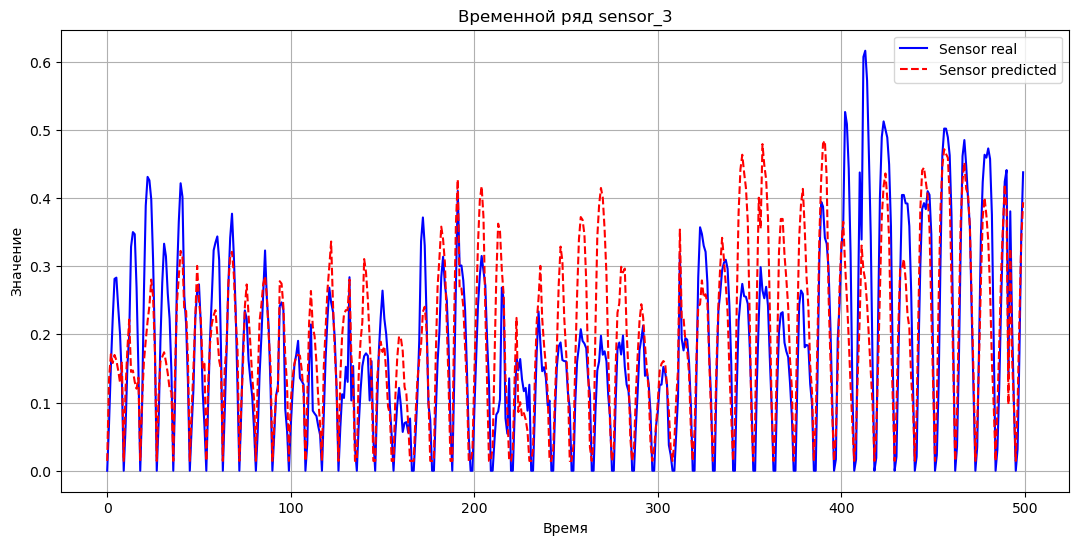

In [78]:
# Предполагается, что df — это ваш DataFrame
plt.figure(figsize=(13, 6))  # Устанавливаем размер графика
plt.plot(df['sensor_3'].iloc[:500], linestyle='-', color='blue', label='Sensor real')
plt.plot(df_dec['sensor_3'].iloc[:500], linestyle='--', color='red', label='Sensor predicted')  # Линия графика
plt.title('Временной ряд sensor_3')  # Заголовок графика
plt.xlabel('Время')  # Подпись оси X
plt.ylabel('Значение')  # Подпись оси Y
plt.legend()  # Легенда
plt.grid(True)  # Сетка
plt.show()  # Отображение графика

### Plain

In [79]:
compressed_main = lz4.frame.compress(main_sensor.tobytes())
decompressed_main = np.frombuffer(lz4.frame.decompress(compressed_main), dtype=np.float32)
assert np.allclose(main_sensor, decompressed_main), "Ошибка восстановления главного сенсора!"


In [80]:
compressed_main

b'\x04"M\x18h@\xecS\x00\x00\x00\x00\x00\x00lc>\x00\x00\xf0\x15\x00\x00\x00\x00\xad\x9a\xf0=\x90m*>N\xcf\x17>\xed\xfe(>\xd9\x89\x1d>R\x0e\x08>\x98%\xe5=\x94\xac\x1a>$\x00\xf1\x00\xb4\x18\xd1=\xa4\xe25>\x98%e>\r1\x05 \x00@\xdd\x02\xe8=\x18\x00@7U\xf6=$\x0012\xdc\xab0\x00\xf1\x08[\xc6B>SHb>\xc1\x0f|>\t\xf2\x94>_\xe8\x85>w\xb9.H\x00\xb1\xd1\x0b\xbd=\xbc\xeb\x1a>\x05\xb3$\x14\x00\x00`\x00@\xc8S\x02>H\x001\xa0\xa3\xc5H\x00\xf1\x08:Z\x0c>&\xe5\x80>N\xcf\x97>\xc8\xc7\xab>J\x90\xa7>\xf2ws\x04\x00\x00\x9c\x00\x00l\x00\xf1\x04\xc4\x14\x92=\xdd\xc8\r>"\xe0j>o\x1e\xa1>\xc8S\x82\x9c\x00\x00\x14\x001\xac`\x16l\x00\xf1\x08\x0ek\xdf=\xd1\x0b=>k\xfc]>\xc5Nl>\x94\xe6t>\xcd\xccL\xe0\x001\xf7$\t$\x00\xf1\x10\x97\xeb\n>\xe9\xbf8>"\xa6\x90>\x9cG\xa8>\xe1$\xab>\xf1=\x99>;\x94f>\x01t4$\x00@\xd9\x89\x9d=T\x001\x1e\xa1z(\x00@g\xbdm>X\x00q|2\xf9=\xbc\x96\xb1\xb4\x00\x00\x0c\x01\x00\xf4\x00qd~}>])\x91\xbc\x00\x00\xf8\x00q\x88\xefI>g\x83\x13H\x00\xf1\x04\xfa\xf5S=\x94\xbd\xbd=\x16\xe9\xbf=g\x83\x93>s]\x91T\x00q\xa8

In [81]:
from tensorflow.keras.layers import Conv1D, Flatten, Reshape

X = main_sensor.reshape(-1, 1)  # Вход автоэнкодера
Y = dependent_sensors   

input_dim = 1  # Вход: главный сенсор
output_dim = Y.shape[1]  # Количество зависимых сенсоров

inputs = Input(shape=(input_dim, 1))  # Добавляем размерность для Conv1D

# Сверточный блок
x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(inputs)
x = Flatten()(x)

# Сжатие
encoded = Dense(input_dim, activation='relu')(x)  # Приводим к целевой форме для Reshape

# Восстановление
x = Dense(input_dim * 16, activation='relu')(encoded)  # Расширяем обратно для Conv1D
x = Reshape((input_dim, 16))(x)  # Преобразуем в (input_dim, 16)
decoded = Conv1D(output_dim, kernel_size=3, activation='linear', padding='same')(x)

# Автоэнкодер
autoencoder = keras.Model(inputs, decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')

# Обучение
autoencoder.fit(X.reshape(-1, 1, 1), Y.reshape(-1, 1, output_dim), epochs=30, batch_size=32, shuffle=True, verbose=1)

# Кодировщик
encoder = keras.Model(inputs, encoded)


Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0382
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 9/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080
Epoch 10/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080
Epoch 11/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 12/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 13/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 14/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 15/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

KeyboardInterrupt: 

In [ ]:
# # Вход: главный сенсор (X), Выход: зависимые сенсоры (Y)
# X = main_sensor.reshape(-1, 1)  # Вход автоэнкодера
# Y = dependent_sensors           # Выход автоэнкодера

# # Создание модели автоэнкодера
# input_dim = 1
# output_dim = Y.shape[1]

# inputs = Input(shape=(input_dim,))
# encoded = Dense(8, activation='relu')(inputs)
# encoded = Dense(4, activation='relu')(encoded)

# decoded = Dense(8, activation='relu')(encoded)
# decoded = Dense(output_dim, activation='sigmoid')(decoded)  # Выход в диапазоне [0,1]

# autoencoder = keras.Model(inputs, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')

# # Обучение автоэнкодера
# autoencoder.fit(X, Y, epochs=20, batch_size=32, shuffle=True, verbose=1)

# # Выделяем кодировщик
# encoder = keras.Model(inputs, encoded)


In [ ]:
compressed_dependent = encoder.predict(X)


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Вход для декодера
decoder_input = Input(shape=(input_dim,))  # Входное сжатое представление

# Восстановление через слои автоэнкодера
decoder_layer1 = autoencoder.layers[-3](decoder_input)  # Dense слой для восстановления
decoder_layer2 = autoencoder.layers[-2](decoder_layer1)  # Reshape слой
decoder_layer3 = autoencoder.layers[-1](decoder_layer2)  # Conv1D слой

# Создаем модель декодера
decoder = Model(decoder_input, decoder_layer3)

# Используем декодер для восстановления зависимых сенсоров
restored_dependent = decoder.predict(compressed_dependent)

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


In [ ]:
# decoder_input = Input(shape=(4,))
# decoder_layer1 = autoencoder.layers[-2](decoder_input)
# decoder_layer2 = autoencoder.layers[-1](decoder_layer1)
# decoder = keras.Model(decoder_input, decoder_layer2)

# restored_dependent = decoder.predict(compressed_dependent)



In [ ]:
# Исходный размер (байты)
original_main_size = main_sensor.nbytes
original_dependent_size = dependent_sensors.nbytes
original_total_size = original_main_size + original_dependent_size

# Сжатый размер (байты)
compressed_main_size = len(compressed_main)
compressed_dependent_size = compressed_dependent.nbytes
compressed_total_size = compressed_main_size + compressed_dependent_size

# Вывод результатов
print(f"🔹 Исходный размер данных: {original_total_size / 1024:.2f} KB")
print(f"🔹 Сжатый размер данных: {compressed_total_size / 1024:.2f} KB")
print(f"⚡ Степень сжатия: {original_total_size / compressed_total_size:.2f}x")

# # Размер LZ4-сжатого главного сенсора
# compressed_main_size = len(compressed_main)

# # Размер кодированного представления зависимых сенсоров
# compressed_dependent_size = compressed_dependent.nbytes

# # Общий размер после сжатия
# compressed_total_size = compressed_main_size + compressed_dependent_size

# print(f"🔹 Сжатый размер данных: {compressed_total_size / 1024:.2f} KB")

🔹 Исходный размер данных: 83.92 KB
🔹 Сжатый размер данных: 36.60 KB
⚡ Степень сжатия: 2.29x


In [ ]:
restored = [x[0] for x in restored_dependent]
restored

[array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20681322, 0.16603756], dtype=float32),
 array([0.22376342, 0.20

In [ ]:
df_dec = pd.DataFrame(restored)
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec

,sensor_3,sensor_4,sensor_5
0,0.223763,0.206813,0.166038
1,0.223763,0.206813,0.166038
2,0.223763,0.206813,0.166038
3,0.223763,0.206813,0.166038
4,0.223763,0.206813,0.166038
...,...,...,...
5366,0.223763,0.206813,0.166038
5367,0.223763,0.206813,0.166038
5368,0.223763,0.206813,0.166038
5369,0.223763,0.206813,0.166038


In [ ]:
print('RMSE:', rmse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MSE:', mse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MAE:', mae(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Total error:', total_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Column error:\n', column_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))

RMSE: 0.049
MSE: 0.002
MAE: 0.00877091953345921
Total error: 1120.075057185583
Column error:
 sensor_3    416.006291
sensor_4    351.012284
sensor_5    353.056483
dtype: float64


In [ ]:
import os
decoder.save("decoder.h5")
with open("decoder.h5", "rb") as f_in:
    compressed_data = lz4.frame.compress(f_in.read())
    with open("decoder.h5.lz4", "wb") as f_out:
        f_out.write(compressed_data)
original_size = os.path.getsize("decoder.h5")
compressed_size = os.path.getsize("decoder.h5.lz4")

In [ ]:
print(f"Размер оригинального файла: {original_size} байт")
print(f"Размер сжатого файла: {compressed_size} байт")

Размер оригинального файла: 16016 байт
Размер сжатого файла: 2531 байт


### DWT

In [ ]:
import numpy as np
import pandas as pd
import pywt
import lz4.frame
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Reshape, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
def apply_dwt(data, wavelet='haar', level=1):
    """Применяет DWT и оставляет только низкочастотные компоненты."""
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs[0]  # Берем только приближенные коэффициенты

def apply_idwt(approx, wavelet='haar', level=1, original_length=1000):
    """Восстанавливает сигнал через IDWT, добавляя нулевые высокочастотные компоненты."""
    coeffs = [approx] + [np.zeros_like(approx)] * level  # Нулевые коэффициенты для деталей
    restored = pywt.waverec(coeffs, wavelet)[:original_length]  # Восстановление
    return restored


In [ ]:
# Главный сенсор (первый столбец)
main_sensor = df.iloc[:, 0].values.astype(np.float32)

# Остальные сенсоры (все кроме первого)
dependent_sensors = df.iloc[:, 1:].values.astype(np.float32)

In [ ]:
def compress_main_sensor(data):
    return lz4.frame.compress(data.tobytes())

def decompress_main_sensor(compressed_data, dtype=np.float32):
    return np.frombuffer(lz4.frame.decompress(compressed_data), dtype=dtype)

compressed_main = compress_main_sensor(main_sensor)
decompressed_main = decompress_main_sensor(compressed_main)


In [ ]:
# Разложение зависимых сенсоров через DWT
X_dwt = np.array([apply_dwt(sensor) for sensor in dependent_sensors.T]).T  # Преобразуем по колонкам
# Обрезаем главный сенсор до размера DWT-коэффициентов
X_resized = main_sensor[:X_dwt.shape[0]]


In [ ]:
X = main_sensor.reshape(-1, 1)  # Главный сенсор (1D вход)
Y = X_dwt  # DWT-коэффициенты зависимых сенсоров

# Определяем архитектуру автоэнкодера
input_dim = 1
output_dim = Y.shape[1]

inputs = Input(shape=(input_dim, 1))  # Conv1D требует 3D вход

# Сверточный блок
x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(inputs)
x = GlobalAveragePooling1D()(x)  # Вместо Flatten()

# Сжатие (латентное пространство)
encoded = Dense(16, activation='relu')(x)

# Восстановление
x = Dense(output_dim, activation='relu')(encoded)  # Восстанавливаем размерность
decoded = Reshape((1, output_dim))(x)  # Теперь корректно
decoded = Conv1D(output_dim, kernel_size=3, activation='linear', padding='same')(decoded)

# Создаем автоэнкодер
autoencoder = keras.Model(inputs, decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')

# Обучение автоэнкодера
autoencoder.fit(X_resized.reshape(-1, 1, 1), X_dwt.reshape(-1, 1, X_dwt.shape[1]), epochs=30, batch_size=32, shuffle=True, verbose=1)
encoder = keras.Model(inputs, encoded)


Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 0.1095
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0666
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.0663
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0642
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 0.0643
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 0.0653
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.0632
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 0.0648
Epoch 9/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0636
Epoch 10/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.0643
Epoch 11/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 0.0636
Epoch 12/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.0649
Epoch 13/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 0.0640
Epoch 14/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 0.0651
Epoch 15/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss

In [ ]:
def compress_dependent_sensors(encoder, main_sensor):
    return encoder.predict(main_sensor.reshape(-1, 1, 1))

compressed_dependent = compress_dependent_sensors(encoder, main_sensor)


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


In [ ]:
# Декодер (восстанавливает зависимые сенсоры)
decoder_input = Input(shape=(16,))
decoder_layer1 = autoencoder.layers[-3](decoder_input)
decoder_layer2 = autoencoder.layers[-2](decoder_layer1)
decoder_layer3 = autoencoder.layers[-1](decoder_layer2)
decoder = keras.Model(decoder_input, decoder_layer3)

# Восстанавливаем коэффициенты DWT
restored_dwt_coeffs = decoder.predict(compressed_dependent)

# Восстанавливаем сигналы через IDWT
restored_dependent_dwt = np.array([apply_idwt(sensor) for sensor in restored_dwt_coeffs.T]).T


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step


In [ ]:
# Размер исходных данных
original_main_size = main_sensor.nbytes
original_dependent_size = dependent_sensors.nbytes
original_total_size = original_main_size + original_dependent_size

# Размер сжатых данных
compressed_main_size = len(compressed_main)
compressed_dependent_size = compressed_dependent.nbytes
compressed_total_size = compressed_main_size + compressed_dependent_size

# Вывод результатов
print(f"🔹 Исходный размер данных: {original_total_size / 1024:.2f} KB")
print(f"🔹 Сжатый размер данных: {compressed_total_size / 1024:.2f} KB")
print(f"⚡ Степень сжатия: {original_total_size / compressed_total_size:.2f}x")


🔹 Исходный размер данных: 83.92 KB
🔹 Сжатый размер данных: 351.31 KB
⚡ Степень сжатия: 0.24x


In [ ]:
restored_dependent_dwt

array([[[0.20728295, 0.19977416, 0.1588426 ]],

       [[0.20728295, 0.19977416, 0.1588426 ]],

       [[0.20975184, 0.20329612, 0.15983318]],

       ...,

       [[0.21162695, 0.20426567, 0.15974496]],

       [[0.21097696, 0.20463477, 0.16012311]],

       [[0.21097696, 0.20463477, 0.16012311]]], dtype=float32)

In [ ]:
restored = [x[0] for x in restored_dependent_dwt]
df_dec = pd.DataFrame(restored)
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec
print('RMSE:', rmse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MSE:', mse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MAE:', mae(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Total error:', total_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Column error:\n', column_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))

RMSE: nan
MSE: nan
MAE: 0.0339345378539108
Total error: 2444.566530634019
Column error:
 sensor_3    833.758304
sensor_4    912.161224
sensor_5    698.647003
dtype: float64


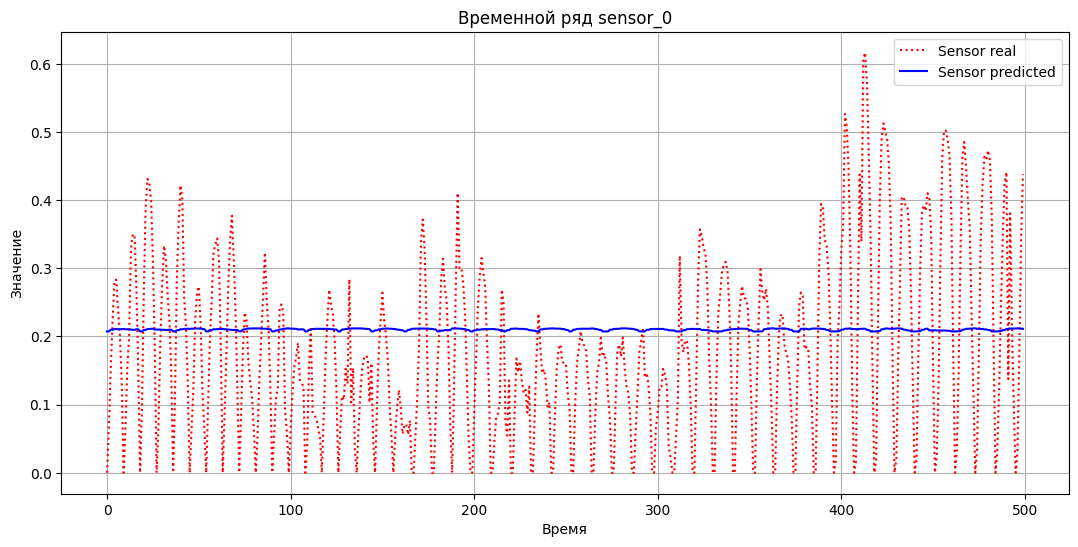

In [ ]:
# Предполагается, что df — это ваш DataFrame
plt.figure(figsize=(13, 6))  # Устанавливаем размер графика
plt.plot(df['sensor_3'].iloc[:500], linestyle='dotted', color='red', label='Sensor real')
plt.plot(df_dec['sensor_3'].iloc[:500], linestyle='-', color='blue', label='Sensor predicted')  # Линия графика
plt.title('Временной ряд sensor_0')  # Заголовок графика
plt.xlabel('Время')  # Подпись оси X
plt.ylabel('Значение')  # Подпись оси Y
plt.legend()  # Легенда
plt.grid(True)  # Сетка
plt.show()  # Отображение графика

## New

In [ ]:
import numpy as np
import pywt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed

# Функция для разложения ряда с помощью DWT
def apply_dwt(data, wavelet='haar', level=1):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs[0]  # Берем только низкочастотные коэффициенты

# Функция для восстановления через IDWT
def apply_idwt(approx, wavelet='haar', level=1, original_length=1000):
    coeffs = [approx] + [np.zeros_like(approx)] * level
    restored = pywt.waverec(coeffs, wavelet)[:original_length]
    return restored

# Главный сенсор (первый столбец)
main_sensor = df.iloc[:, 0].values.astype(np.float32)

# Остальные сенсоры (все кроме первого)
dependent_sensors = df.iloc[:, 1:].values.astype(np.float32)

# Разложение зависимых сенсоров через DWT
level = 1
X_dwt = np.array([apply_dwt(sensor, level=level) for sensor in dependent_sensors.T]).T  

# Обрезаем главный сенсор до размера DWT-коэффициентов
X_resized = main_sensor[:X_dwt.shape[0]].reshape(-1, 1)

# Создаем автоэнкодер с LSTM
timesteps = X_resized.shape[0]
input_dim = 1
output_dim = X_dwt.shape[1]

inputs = Input(shape=(input_dim, 1))
x = LSTM(32, activation='relu', return_sequences=False)(inputs)
x = Dense(16, activation='relu')(x)
encoded = Dense(8, activation='relu')(x)

# Декодер
x = Dense(16, activation='relu')(encoded)
x = RepeatVector(input_dim)(x)
x = LSTM(32, activation='relu', return_sequences=True)(x)
decoded = TimeDistributed(Dense(output_dim, activation='linear'))(x)

autoencoder = keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Обучение автоэнкодера
autoencoder.fit(X_resized.reshape(-1, 1, 1), X_dwt.reshape(-1, 1, output_dim),
                epochs=50, batch_size=32, shuffle=True, verbose=1)

# Кодировщик
encoder = keras.Model(inputs, encoded)


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1250
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0637
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0656  
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0652  
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0638  
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0674  
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0638  
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.0663
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 0.0615
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0639  
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.0647
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0648  
Epoch 13/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0643  
Epoch 14/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.0646
Epoch 15/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

In [ ]:
# Сжатие зависимых сенсоров через автоэнкодер
compressed_dependent = encoder.predict(X_resized.reshape(-1, 1, 1))


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step


In [ ]:
decoder_input = Input(shape=(8,))
# Add a Dense layer to expand the input to the expected shape
expanded_input = Dense(16, activation='relu')(decoder_input)
decoder_layer1 = autoencoder.layers[-5](expanded_input)
decoder_layer2 = autoencoder.layers[-4](decoder_layer1)
decoder_layer3 = autoencoder.layers[-3](decoder_layer2)
decoder_layer4 = autoencoder.layers[-2](decoder_layer3)
decoder_layer5 = autoencoder.layers[-1](decoder_layer4)
decoder = keras.Model(decoder_input, decoder_layer5)
# Восстанавливаем DWT-коэффициенты
restored_dwt_coeffs = decoder.predict(compressed_dependent)

# Восстанавливаем сигналы через IDWT
restored_dependent_dwt = np.array([apply_idwt(sensor) for sensor in restored_dwt_coeffs.T]).T

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
restored = [x[0] for x in restored_dependent_dwt]
df_dec = pd.DataFrame(restored)
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec
print('RMSE:', rmse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MSE:', mse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MAE:', mae(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Total error:', total_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Column error:\n', column_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))

RMSE: nan
MSE: nan
MAE: 0.0338086769411208
Total error: 2462.360859185891
Column error:
 sensor_3    839.080863
sensor_4    915.302333
sensor_5    707.977664
dtype: float64


In [ ]:

# Декодер (восстанавливает зависимые сенсоры)
decoder_input = Input(shape=(8,))
decoder_layer1 = autoencoder.layers[-5](decoder_input)
decoder_layer2 = autoencoder.layers[-4](decoder_layer1)
decoder_layer3 = autoencoder.layers[-3](decoder_layer2)
decoder_layer4 = autoencoder.layers[-2](decoder_layer3)
decoder_layer5 = autoencoder.layers[-1](decoder_layer4)
decoder = keras.Model(decoder_input, decoder_layer5)

# Восстанавливаем DWT-коэффициенты
restored_dwt_coeffs = decoder.predict(compressed_dependent)

# Восстанавливаем сигналы через IDWT
restored_dependent_dwt = np.array([apply_idwt(sensor) for sensor in restored_dwt_coeffs.T]).T

ValueError: Input 0 of layer "dense_9" is incompatible with the layer: expected axis -1 of input shape to have value 16, but received input with shape (None, 8)

## LSTM

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, RepeatVector, TimeDistributed
# from tensorflow.keras.models import Model

# # Формируем данные
# main_sensor = df.iloc[:, 0].values.reshape(-1, 1)  # Главный сенсор
# dependent_sensors = df.iloc[:, 1:].values  # Остальные сенсоры
# timesteps = main_sensor.shape[0]  # Количество временных шагов
# output_dim = dependent_sensors.shape[1]  # Число зависимых сенсоров

# # Создание автоэнкодера
# input_layer = Input(shape=(timesteps, 1))  # (batch, timesteps, channels)

# # Энкодер
# x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
# x = LSTM(16, activation='relu', return_sequences=False)(x)  # Сжимаем временные зависимости
# encoded = Dense(16, activation='relu')(x)  # Кодировка

# # Декодер
# x = RepeatVector(timesteps)(encoded)  # Разворачиваем обратно
# x = LSTM(16, activation='relu', return_sequences=True)(x)
# x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
# decoded = TimeDistributed(Dense(output_dim))(x)  # Выходное измерение = числу зависимых сенсоров

# # Создание модели
# autoencoder = Model(input_layer, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')

# # Обучение модели
# autoencoder.fit(main_sensor.reshape(1, timesteps, 1), 
#                 dependent_sensors.reshape(1, timesteps, output_dim), 
#                 epochs=50, batch_size=1, shuffle=False, verbose=1)

# # Кодировщик
# encoder = Model(input_layer, encoded)

# # Функция для сжатия
# def compress_dependent_sensors(encoder, main_sensor):
#     return encoder.predict(main_sensor.reshape(1, timesteps, 1))

# compressed_dependent = compress_dependent_sensors(encoder, main_sensor)

# # Декодер (восстанавливает зависимые сенсоры)
# decoder_input = Input(shape=(16,))
# x = RepeatVector(timesteps)(decoder_input)
# x = autoencoder.layers[-3](x)
# x = autoencoder.layers[-2](x)
# decoder_output = autoencoder.layers[-1](x)
# decoder = Model(decoder_input, decoder_output)

# # Восстановление зависимых сенсоров
# restored_dependent = decoder.predict(compressed_dependent)


Epoch 1/50


In [ ]:
df1 = df.iloc[:1000]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

# Формируем данные
main_sensor = df1.iloc[:, 0].values.reshape(-1, 1)  # Главный сенсор
dependent_sensors = df1.iloc[:, 1:].values  # Остальные сенсоры
timesteps = main_sensor.shape[0]  # Количество временных шагов
output_dim = dependent_sensors.shape[1]  # Число зависимых сенсоров

# Входной слой
input_layer = Input(shape=(timesteps, 1))  # (batch, timesteps, channels)

# Энкодер: убираем разреженность
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
x = Flatten()(x)
encoded = Dense(32, activation='relu')(x)  # Латентное представление

# Декодер
x = Dense(timesteps * 32, activation='relu')(encoded)
x = Reshape((timesteps, 32))(x)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
decoded = Conv1D(output_dim, kernel_size=3, activation='linear', padding='same')(x)  # Восстановленные ряды

# Создаем автоэнкодер
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Обучение модели
autoencoder.fit(main_sensor.reshape(1, timesteps, 1), 
                dependent_sensors.reshape(1, timesteps, output_dim), 
                epochs=50, batch_size=8, shuffle=False, verbose=1)

# Кодировщик
encoder = Model(input_layer, encoded)

# Функция для сжатия
def compress_dependent_sensors(encoder, main_sensor):
    return encoder.predict(main_sensor.reshape(1, timesteps, 1))

compressed_dependent = compress_dependent_sensors(encoder, main_sensor)

# Декодер
decoder_input = Input(shape=(32,))
x = Dense(timesteps * 32, activation='relu')(decoder_input)
x = Reshape((timesteps, 32))(x)
x = autoencoder.layers[-2](x)
decoder_output = autoencoder.layers[-1](x)
decoder = Model(decoder_input, decoder_output)

# Восстановление зависимых сенсоров
restored_dependent = decoder.predict(compressed_dependent)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step - loss: 0.0533
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0478
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0355
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0194
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0150
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0132
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0051
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0026
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0033
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0036
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0029
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0021
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0021
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0022
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━

In [ ]:
len(restored_dependent)

1

In [ ]:
df_dec = pd.DataFrame(restored_dependent[0])
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec
print('RMSE:', rmse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']].iloc[:1000], df_dec))
print('MSE:', mse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']].iloc[:1000], df_dec))
print('MAE:', mae(df_wind[['sensor_3', 'sensor_4', 'sensor_5']].iloc[:1000], df_dec))
print('Total error:', total_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']].iloc[:1000], df_dec))
print('Column error:\n', column_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']].iloc[:1000], df_dec))

RMSE: 0.086
MSE: 0.007
MAE: 0.03293343254458161
Total error: 391.53223657866056
Column error:
 sensor_3    148.936025
sensor_4    136.996147
sensor_5    105.600065
dtype: float64


## Trans

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Flatten, Reshape
from tensorflow.keras.models import Model

# Данные
main_sensor = df.iloc[:, 0].values.reshape(-1, 1)  # Главный сенсор
dependent_sensors = df.iloc[:, 1:].values  # Остальные сенсоры
timesteps = main_sensor.shape[0]  # Количество временных шагов
output_dim = dependent_sensors.shape[1]  # Число зависимых сенсоров

# === Self-Attention блок ===
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs  # Skip connection

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res  # Еще один Skip connection

# === Автоэнкодер ===
input_layer = Input(shape=(timesteps, 1))  # Вход: главный сенсор

# === Энкодер ===
x = transformer_encoder(input_layer, head_size=64, num_heads=4, ff_dim=128)
x = Flatten()(x)
encoded = Dense(32, activation='relu')(x)  # Сжатое представление

# === Декодер ===
x = Dense(timesteps * 32, activation='relu')(encoded)
x = Reshape((timesteps, 32))(x)
decoded = Dense(output_dim, activation='linear')(x)  # Восстановленные сенсоры

# === Компиляция модели ===
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# === Обучение ===
autoencoder.fit(main_sensor.reshape(1, timesteps, 1), 
                dependent_sensors.reshape(1, timesteps, output_dim), 
                epochs=50, batch_size=1, shuffle=False, verbose=1)

# === Кодировщик ===
encoder = Model(input_layer, encoded)

# === Функция сжатия ===
def compress_dependent_sensors(encoder, main_sensor):
    return encoder.predict(main_sensor.reshape(1, timesteps, 1))

compressed_dependent = compress_dependent_sensors(encoder, main_sensor)

# === Декодер ===
decoder_input = Input(shape=(32,))
x = Dense(timesteps * 32, activation='relu')(decoder_input)
x = Reshape((timesteps, 32))(x)
decoder_output = autoencoder.layers[-1](x)
decoder = Model(decoder_input, decoder_output)

# === Восстановление зависимых сенсоров ===
restored_dependent = decoder.predict(compressed_dependent)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0757
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step - loss: 0.0748
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step - loss: 0.0739
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step - loss: 0.0726
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step - loss: 0.0708
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step - loss: 0.0680
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step - loss: 0.0642
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step - loss: 0.0595
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step - loss: 0.0538
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step - loss: 0.0474
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step - loss: 0.0404
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - loss: 0.0332
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step - loss: 0.0265
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step - loss: 0.0213
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step - loss: 0.0184
Epoch 16/50
1/1 ━━━━━━

In [ ]:
restored_dependent

array([[[ 0.056105  , -0.04311186,  0.04697923],
        [-0.02958975,  0.00418208,  0.04870737],
        [ 0.10758165,  0.0018437 ,  0.00375578],
        ...,
        [ 0.08784125,  0.00056764,  0.07029693],
        [ 0.02005295,  0.04333524,  0.10955424],
        [ 0.08194717, -0.00742864,  0.041898  ]]], dtype=float32)

In [ ]:
df_dec = pd.DataFrame(restored_dependent[0])
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec
print('RMSE:', rmse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MSE:', mse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MAE:', mae(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Total error:', total_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Column error:\n', column_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))

RMSE: 0.133
MSE: 0.018
MAE: 0.07077302404571108
Total error: 3166.2825707763595
Column error:
 sensor_3    1106.702196
sensor_4    1224.378157
sensor_5     835.202218
dtype: float64


## TSN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Reshape, Add, Activation, LayerNormalization
from tensorflow.keras.models import Model

# === Параметры ===
timesteps = main_sensor.shape[0]  # Длина временного ряда
output_dim = dependent_sensors.shape[1]  # Количество зависимых сенсоров
latent_dim = 16  # Размер скрытого представления

# === TCN Блок ===
def tcn_block(x, filters, kernel_size, dilation_rate):
    skip = x
    if x.shape[-1] != filters:  # Adjust input shape if necessary
        skip = Conv1D(filters, kernel_size=1, padding="same")(x)
    x = Conv1D(filters, kernel_size, padding="same", dilation_rate=dilation_rate, activation="relu")(x)
    x = Conv1D(filters, kernel_size, padding="same", dilation_rate=dilation_rate)(x)
    x = Add()([x, skip])  # Residual connection
    x = Activation("relu")(x)
    x = LayerNormalization()(x)
    return x

# === Энкодер ===
input_layer = Input(shape=(timesteps, 1))
x = tcn_block(input_layer, 32, 3, dilation_rate=1)
x = tcn_block(x, 32, 3, dilation_rate=2)  # Ensure consistent filter size
x = tcn_block(x, 32, 3, dilation_rate=4)  # Ensure consistent filter size
x = Flatten()(x)
encoded = Dense(latent_dim, activation="relu")(x)  # Латентное представление

# === Декодер ===
x = Dense(timesteps * latent_dim, activation="relu")(encoded)
x = Reshape((timesteps, latent_dim))(x)
x = Conv1D(64, 3, padding="same", activation="relu")(x)
decoded = Conv1D(output_dim, 3, padding="same", activation="linear")(x)  # Восстановленные данные

# === Создаем модель ===
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# === Обучение ===
autoencoder.fit(main_sensor.reshape(1, timesteps, 1), 
                dependent_sensors.reshape(1, timesteps, output_dim), 
                epochs=50, batch_size=1, verbose=1)

# === Кодировщик ===
encoder = Model(input_layer, encoded)

# === Декодер ===
decoder_input = Input(shape=(latent_dim,))
x = Dense(timesteps * latent_dim, activation="relu")(decoder_input)
x = Reshape((timesteps, latent_dim))(x)
x = autoencoder.layers[-2](x)
decoder_output = autoencoder.layers[-1](x)
decoder = Model(decoder_input, decoder_output)

# === Сжатие и восстановление ===
compressed_dependent = encoder.predict(main_sensor.reshape(1, timesteps, 1))
restored_dependent = decoder.predict(compressed_dependent)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0753
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1951
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0730
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0719
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0706
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0650
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0597
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0501
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0382
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0280
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0254
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0150
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0139
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0110
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0083
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
restored_dependent

array([[[ 0.01297282,  0.0678226 , -0.11363906],
        [-0.02993756,  0.23898853,  0.11824781],
        [ 0.18738009,  0.26095995,  0.10083752],
        ...,
        [ 0.13488671,  0.17390661,  0.24043901],
        [ 0.174104  ,  0.10839196,  0.07400285],
        [ 0.11624812,  0.05801732,  0.12616135]]], dtype=float32)

In [ ]:
df_dec = pd.DataFrame(restored_dependent[0])
df_dec.columns = ['sensor_3', 'sensor_4', 'sensor_5']
df_dec
print('RMSE:', rmse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MSE:', mse(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('MAE:', mae(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Total error:', total_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))
print('Column error:\n', column_error(df_wind[['sensor_3', 'sensor_4', 'sensor_5']], df_dec))

RMSE: 0.135
MSE: 0.018
MAE: 0.04185965000186915
Total error: 2611.6890063024557
Column error:
 sensor_3    906.466116
sensor_4    957.031164
sensor_5    748.191727
dtype: float64


## SZ3

In [76]:
import numpy as np
from pathlib import Path
import sys
import pandas as pd
from sz.SZ3.tools.pysz.pysz import SZ

In [110]:
data = df.values.transpose()

In [111]:
df

,sensor_0,sensor_3,sensor_4,sensor_5
0,0.000000,0.000000,0.000000,0.000000
1,0.117483,0.068950,0.069215,0.019261
2,0.166434,0.152344,0.127238,0.069999
3,0.148252,0.222754,0.135462,0.106351
4,0.165035,0.281452,0.207547,0.159913
...,...,...,...,...
5366,0.412587,0.190855,0.240445,0.093544
5367,0.381818,0.235148,0.203423,0.093049
5368,0.345455,0.213067,0.163038,0.086803
5369,0.296032,0.159991,0.130950,0.079433


In [112]:
get_float_bytes(df)

Размер исходных данных: 1374976 бит
Размер исходных данных: 171872 байт 



In [113]:
data

array([[0.        , 0.11748252, 0.16643357, ..., 0.34545455, 0.29603168,
        0.1972028 ],
       [0.        , 0.06894999, 0.15234413, ..., 0.21306746, 0.15999051,
        0.12320271],
       [0.        , 0.06921519, 0.12723754, ..., 0.16303822, 0.13094975,
        0.07595549],
       [0.        , 0.01926123, 0.06999891, ..., 0.08680267, 0.07943277,
        0.04984707]])

In [114]:
lib_extension = {
    "darwin": "libSZ3c.dylib",  # macOS
    "win32": "SZ3c.dll",  # Windows
}.get(sys.platform, "libSZ3c.so")  # Linux (по умолчанию)
lib_extension

'libSZ3c.dylib'

In [115]:
sz = SZ(f"/usr/local/lib/{lib_extension}")

In [121]:
mem = 0
data_dec = []
for d in data:
    data_cmpr, cmpr_ratio = sz.compress(d, eb_mode=0, eb_pwr=0, eb_rel=0, eb_abs=0.03)
    print(data_cmpr.nbytes)
    data_dec.append(sz.decompress(data_cmpr, d.shape, d.dtype))
    mem += data_cmpr.nbytes
    print(mean_squared_error(d, sz.decompress(data_cmpr, d.shape, d.dtype)))
print(mem)

2082
0.0002766918524623217
2145
0.00026444352170291183
2129
0.00027273231822622947
1867
0.00028175398323767334
8223


In [172]:
print(round(mean_squared_error(data, data_dec), 6))

3e-05


In [88]:
data_cmpr, cmpr_ratio = sz.compress(data, eb_mode=0, eb_pwr=0, eb_rel=0, eb_abs=0.01)
print(f"Compression ratio: {cmpr_ratio}")

Compression ratio: 14.752961373390558


In [89]:
len(data_cmpr)

11650

In [192]:
size_in_bytes = data_cmpr.nbytes
print(f"Объем массива: {size_in_bytes} байт")

Объем массива: 25525 байт


In [157]:
data_dec = sz.decompress(data_cmpr, data.shape, data.dtype)
sz.verify(data, data_dec)

abs err=0.001


(0.0009999999999999731, 62.95910839584953, 0.0007112865232694253)

In [148]:
mean_squared_error(data_dec, data)

3.1730034353751545e-07

## SZ + Conv

In [174]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Reshape, LSTM, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

In [90]:
#best
df = df_wind[['sensor_0', 'sensor_3', 'sensor_4', 'sensor_5']].copy()
# Выбираем главный сенсор (первый столбец)
main_sensor = df.iloc[:, 0].values.astype(np.float32)

# Выбираем зависимые сенсоры (все кроме первого столбца)
dependent_sensors = df.iloc[:, 1:].values.astype(np.float32)
window_size = 10

# Функция для разбиения на окна
def create_windows(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data) - window_size)])

X = create_windows(main_sensor.reshape(-1, 1), window_size)  # Только главный сенсор
Y = create_windows(df.values, window_size)  # Восстанавливаем все сенсоры

X = X.reshape(X.shape[0], X.shape[1], 1)  # (samples, time_steps, 1)
Y = Y.reshape(Y.shape[0], Y.shape[1], Y.shape[2])  # (samples, time_steps, 4)

input_dim = window_size
output_dim = Y.shape[2]  # 4 сенсора
encoding_dim = 2  # Размерность сжатого представления

# Архитектура автоэнкодера
inputs = Input(shape=(input_dim, 1))
x = Conv1D(4, kernel_size=3, activation='selu', padding='same')(inputs)  # Уменьшили число фильтров
x = Flatten()(x)
encoded = Dense(encoding_dim, activation='selu', name="bottleneck")(x)  # Кодируем X

# Декодер (восстанавливаем все 4 сенсора)
x = Dense(input_dim * output_dim, activation='selu')(encoded)
x = Reshape((input_dim, output_dim))(x)
decoded = Conv1D(output_dim, kernel_size=3, activation='selu', padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Обучение
autoencoder.fit(X, Y, shuffle=True, epochs=30, batch_size=4, verbose=1)

# Кодировщик (сжатие X)
encoder = Model(inputs, encoded)

# Декодер (восстановление всех сенсоров)
encoded_input = Input(shape=(encoding_dim,))
x = Dense(input_dim * output_dim, activation='selu')(encoded_input)
x = Reshape((input_dim, output_dim))(x)
decoded_output = Conv1D(output_dim, kernel_size=3, activation='selu', padding='same')(x)
decoder = Model(encoded_input, decoded_output)

Epoch 1/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0399
Epoch 2/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0104
Epoch 3/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0100
Epoch 4/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0101
Epoch 5/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0099
Epoch 6/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0099
Epoch 7/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0098
Epoch 8/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0098
Epoch 9/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0097
Epoch 10/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0097
Epoch 11/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0096
Epoch 12/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0098
Epoch 13/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0097
Epoch 14/30
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0095
Epoch 15/30
1341/1341 ━━━━━━━

KeyboardInterrupt: 

In [176]:
#save dec+enc
encoder.save("encoder.h5")
with open("encoder.h5", "rb") as f_in:
    compressed_encoder = lz4.frame.compress(f_in.read())
print('enc:', len(compressed_decoder))
decoder.save("decoder.h5")
with open("decoder.h5", "rb") as f_in:
    compressed_decoder = lz4.frame.compress(f_in.read())
print('dec:', len(compressed_decoder))
compressed_main = lz4.frame.compress(main_sensor.tobytes())
decompressed_main = np.frombuffer(lz4.frame.decompress(compressed_main), dtype=np.float32)
print('main:', len(compressed_main))

enc: 2747
dec: 3029
main: 15994


In [188]:
# Сохранение весов в массив
encoder_weights = encoder.get_weights()
encoder_weights_array = np.array(encoder_weights, dtype=object) 
encoder_weights_array

array([array([[[-0.33191064, -0.30232286, -0.5340995 ,  0.5274248 ]],

              [[-0.38706186,  0.3315786 ,  0.31514454,  0.24630095]],

              [[-0.07153147,  0.15053287, -0.3647175 ,  0.5064364 ]]],
             dtype=float32)                                           ,
       array([ 0.22103126,  0.05046909,  0.1176609 , -0.20115551], dtype=float32),
       array([[-0.15745485, -0.43245798],
              [-0.31407136,  0.0280147 ],
              [ 0.17412205,  0.3119225 ],
              [-0.19097805, -0.28732586],
              [-0.2513313 , -0.04832087],
              [-0.33873984,  0.36948976],
              [ 0.13785815, -0.33138472],
              [ 0.48601326, -0.12093212],
              [ 0.3238593 , -0.49083778],
              [ 0.0178881 , -0.31792188],
              [ 0.01297161, -0.6240355 ],
              [ 0.26549485, -0.21140721],
              [ 0.03836635,  0.09955379],
              [-0.07286333,  0.2957399 ],
              [ 0.393307  , -0.37294447],
  

In [189]:
encoder_weights_array[0]

array([[[-0.33191064, -0.30232286, -0.5340995 ,  0.5274248 ]],

       [[-0.38706186,  0.3315786 ,  0.31514454,  0.24630095]],

       [[-0.07153147,  0.15053287, -0.3647175 ,  0.5064364 ]]],
      dtype=float32)

In [ ]:
# Восстановление весов
reconstructed_encoder.set_weights(encoder_weights_array.tolist())

### Best

In [101]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, SeparableConv1D
from tensorflow.keras.models import Model
import lz4.frame
X = main_sensor.reshape(-1, 1)  # Вход автоэнкодера
Y = dependent_sensors
# Гиперпараметры
window_size = 64
X_windows = []
Y_targets = []
output_dim = Y.shape[1]
for i in range(len(X) - window_size):
    X_windows.append(X[i:i+window_size])
    Y_targets.append(Y[i+window_size]) 

X_windows = np.array(X_windows).reshape(-1, window_size, 1)
Y_targets = np.array(Y_targets).reshape(-1, output_dim)

X_windows = np.array(X_windows).reshape(-1, window_size, 1)
Y_targets = np.array(Y_targets).reshape(-1, output_dim)
output_dim = Y.shape[1]

inputs = Input(shape=(window_size, 1))
x = SeparableConv1D(2, kernel_size=3, activation='selu', padding='same')(inputs)  # Глубинная свёртка
x = Flatten()(x)
x = Dense(4, activation='selu')(x)  
outputs = Dense(output_dim, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

model.fit(X_windows, Y_targets, epochs=50, batch_size=64, verbose=1)

preds = model.predict(X_windows)
for i in range(output_dim):
    rmse = mean_squared_error(Y_targets[:, i], preds[:, i])
    print(f"RMSE sen_{i+3}: {rmse:.6f}")

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1011
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0394
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0143
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117
Epoch 14/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113
Epoch 15/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111
Epoch 16/50
83/83 ━

In [102]:
# Сохраняем модель в формате SavedModel
model.export("saved_model")  # Сохраняется в папку

# Загружаем и конвертируем в tflite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
#converter.target_spec.supported_types = [tf.float32]  # Без квантизации
tflite_model = converter.convert()

# Сохраняем tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 1), dtype=tf.float32, name='keras_tensor_17')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5647641488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5647640080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5647641664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5644468288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5644469168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5644468816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5690167664: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1743864414.226572 9228190 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1743864414.226627 9228190 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-04-05 17:46:54.227037: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-04-05 17:46:54.228116: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-04-05 17:46:54.228134: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model
2025-04-05 17:46:54.245404: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-04-05 17:46:54.300712: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: saved_model
2025-04-05 17:46:54.329536: I tensorflow/cc/saved_model/loader.cc:317] SavedModel load for tags { serve }; Status: success: OK. Took 102533 microseconds.


In [103]:
import lz4.frame

# Чтение и сжатие модели
with open("model.tflite", "rb") as f:
    tflite_bytes = f.read()
    compressed_model = lz4.frame.compress(tflite_bytes)

# Сохраняем сжатую модель
with open("model.tflite.lz4", "wb") as f:
    f.write(compressed_model)

print(f"📦 Размер после сжатия: {len(compressed_model)} байт")

📦 Размер после сжатия: 5353 байт


In [104]:
# Распаковка обратно
with open("model.tflite.lz4", "rb") as f:
    compressed_data = f.read()
    decompressed_tflite = lz4.frame.decompress(compressed_data)

# Загрузка в TFLite-интерпретатор
interpreter = tf.lite.Interpreter(model_content=decompressed_tflite)
interpreter.allocate_tensors()

# Получение инфо
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [105]:
restored_Y = []

for i in range(len(X_windows)):
    input_tensor = X_windows[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    restored_Y.append(output[0])

restored_Y = np.array(restored_Y)

In [109]:
for i in range(output_dim):
    rmse = mean_squared_error(Y[window_size:, i], restored_Y[:, i])
    print(f"MSE sen_{i+3}: {rmse:.6f}")

MSE sen_3: 0.010364
MSE sen_4: 0.010174
MSE sen_5: 0.007140
